In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
from torch_geometric.data import Data, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

In [2]:
def create_graph(df_i, distance):

    distance_threshold = distance

    # Create an empty nx graph
    G = nx.Graph()

    # Iterate through each node in the dataset
    for i in range(len(df_i)):
        lat1, lon1 = df_i.iloc[i]['latitude'], df_i.iloc[i]['longitude']
        pm = df_i.iloc[i]['PM25_Concentration']
        weather = df_i.iloc[i]['weather']
        wind_speed = df_i.iloc[i]['wind_speed']
        wind_direction = df_i.iloc[i]['wind_direction']
        temperature = df_i.iloc[i]['temperature']

        # Add the current node to the nx graph
        G.add_node(i, pm=pm, weather = weather, wind_speed = wind_speed, wind_direction = wind_direction, temperature = temperature)

        # Iterate through the remaining nodes
        for j in range(i + 1, len(df_i)):
            lat2, lon2 = df_i.iloc[j]['latitude'], df_i.iloc[j]['longitude']

            # Calculate the distance between the coordinates using the Haversine formula
            distance = hs.haversine((lat1, lon1), (lat2, lon2))

            # Add an edge between the current pair of nodes in the nx graph
            G.add_edge(i, j, weight = 1/distance)
        
    return G

In [3]:
def dataset_generation(G):
    node_features = [(G.nodes[node]['weather'], G.nodes[node]['wind_speed'], G.nodes[node]['wind_direction'], G.nodes[node]['temperature']) for node in G.nodes]

    edge_weights = []
    undirected_edges = []
    for edge in G.edges:
        undirected_edges.append(edge)
        undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
        edge_weights.append(G.get_edge_data(edge[0], edge[1]))
        edge_weights.append(G.get_edge_data(edge[1], edge[0]))

    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)
    
    n_train = 22    
    train_mask[:n_train] = True
    test_mask[n_train:] = True
    
    adj_matrix = nx.adjacency_matrix(G).todense()

    test_adj = []
    for i in range(len(adj_matrix[n_train:])):
        test_adj.append(adj_matrix[i][n_train:])
        
    train_adj = []
    for i in range(len(adj_matrix[:n_train])):
        train_adj.append(adj_matrix[i][:n_train])    

    adj_matrix = torch.tensor(np.stack(adj_matrix), dtype = torch.float)
    train_adj = torch.tensor(np.stack(train_adj), dtype = torch.float)
    test_adj = torch.tensor(np.stack(test_adj), dtype = torch.float)

    data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)
    return data, adj_matrix, train_adj, test_adj

In [4]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = DenseGCNConv(input_dim, 16)
        self.conv2 = DenseGCNConv(16, 8)
        self.linear1 = nn.Linear(8, 8)
        self.linear2 = nn.Linear(8, 1)

    def forward(self, x, adj):
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = self.conv2(x, adj)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [5]:
def run_models(data, adj_matrix, train_adj):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RegressionModel(input_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    train_rmse_list = []
    test_rmse_list = []
    min_test_rmse = 100000

    for epoch in range(2500):
        optimizer.zero_grad()
        out = model(data.x[data.train_mask].to(device), train_adj).flatten()
        loss = criterion(out.squeeze(), data.y[data.train_mask].squeeze())
        loss.backward()
        optimizer.step()
        if(epoch%20==0):
            model.eval()
            with torch.no_grad():
                out = model(data.x.to(device), adj_matrix)  # Predicted PM values
                out = out.flatten()
                test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
                
                out_train = model(data.x[data.train_mask].to(device), train_adj).flatten()
                train_rmse = torch.sqrt(torch.mean((out_train.squeeze() - data.y[data.train_mask].squeeze())**2))
                
                train_rmse_list.append(train_rmse.item())
                test_rmse_list.append(test_rmse.item())
                min_test_rmse = min(min_test_rmse, test_rmse.item())
            model.train()
    
    plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Train Loss')
    plt.plot(range(len(test_rmse_list)), test_rmse_list, label='Test Loss')
    plt.title('Train and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), adj_matrix)  # Predicted PM values
        out = out.flatten()
        gnn_test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))

        out_train = model(data.x[data.train_mask].to(device), train_adj).flatten()
        gnn_train_rmse = torch.sqrt(torch.mean((out_train.squeeze() - data.y[data.train_mask].squeeze())**2))
    
    train_mean = torch.mean(data.y[data.train_mask])
    mean_rmse = torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))


    
    X_train = data.x[data.train_mask].numpy()
    y_train = data.y[data.train_mask].numpy().reshape(-1)
    X_test = data.x[data.test_mask].numpy()
    y_test = data.y[data.test_mask].numpy().reshape(-1)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    rf_train_rmse = torch.sqrt(torch.mean((torch.tensor(y_train_pred) - data.y[data.train_mask])**2))
    rf_test_rmse = torch.sqrt(torch.mean((torch.tensor(y_test_pred) - data.y[data.test_mask])**2))
    
    return gnn_train_rmse, gnn_test_rmse, mean_rmse, rf_train_rmse, rf_test_rmse, train_rmse_list, test_rmse_list, min_test_rmse

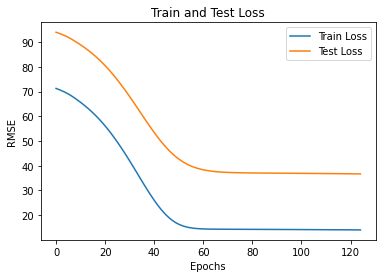

Test RMSE at timestamp 2014-06-01 00:00:00
GNN:  tensor(36.6826)
Min Test RMSE:  36.692691802978516
RF:  tensor(30.7320, dtype=torch.float64)
Mean:  tensor(30.1490)
----------------------------------------


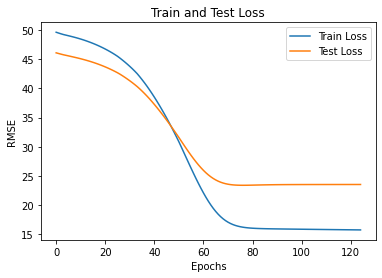

Test RMSE at timestamp 2014-06-02 00:00:00
GNN:  tensor(23.5567)
Min Test RMSE:  23.421337127685547
RF:  tensor(26.6945, dtype=torch.float64)
Mean:  tensor(24.0871)
----------------------------------------


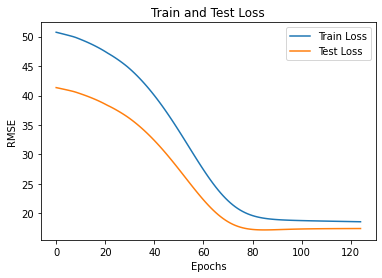

Test RMSE at timestamp 2014-06-03 00:00:00
GNN:  tensor(17.4435)
Min Test RMSE:  17.207061767578125
RF:  tensor(24.9722, dtype=torch.float64)
Mean:  tensor(20.2374)
----------------------------------------


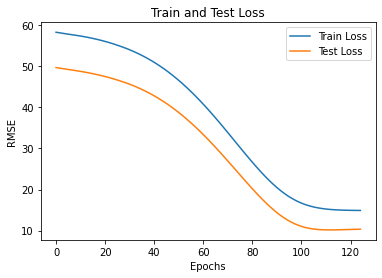

Test RMSE at timestamp 2014-06-04 00:00:00
GNN:  tensor(10.3650)
Min Test RMSE:  10.175660133361816
RF:  tensor(16.9135, dtype=torch.float64)
Mean:  tensor(12.4958)
----------------------------------------


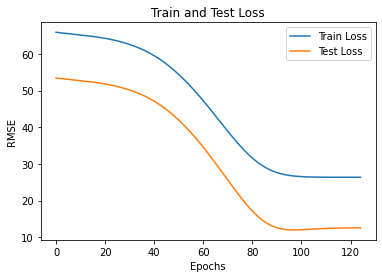

Test RMSE at timestamp 2014-06-05 00:00:00
GNN:  tensor(12.5716)
Min Test RMSE:  11.9876070022583
RF:  tensor(15.7982, dtype=torch.float64)
Mean:  tensor(14.8339)
----------------------------------------


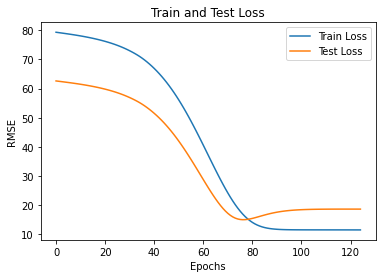

Test RMSE at timestamp 2014-06-06 00:00:00
GNN:  tensor(18.6886)
Min Test RMSE:  15.065003395080566
RF:  tensor(22.5694, dtype=torch.float64)
Mean:  tensor(23.2789)
----------------------------------------


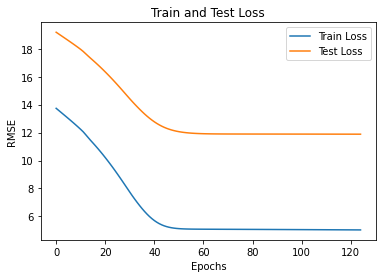

Test RMSE at timestamp 2014-06-07 00:00:00
GNN:  tensor(11.8841)
Min Test RMSE:  11.884471893310547
RF:  tensor(11.9679, dtype=torch.float64)
Mean:  tensor(11.3811)
----------------------------------------


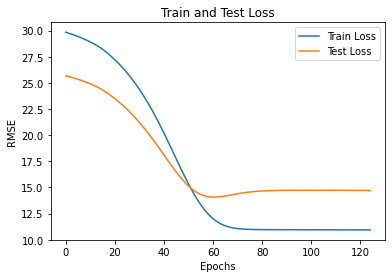

Test RMSE at timestamp 2014-06-08 00:00:00
GNN:  tensor(14.7088)
Min Test RMSE:  14.073224067687988
RF:  tensor(17.2834, dtype=torch.float64)
Mean:  tensor(15.4232)
----------------------------------------


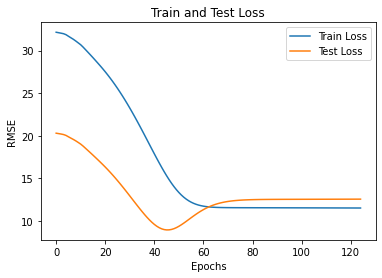

Test RMSE at timestamp 2014-06-09 00:00:00
GNN:  tensor(12.5604)
Min Test RMSE:  8.947010040283203
RF:  tensor(14.3084, dtype=torch.float64)
Mean:  tensor(14.6546)
----------------------------------------


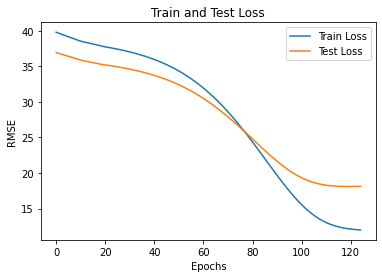

Test RMSE at timestamp 2014-06-10 00:00:00
GNN:  tensor(18.1316)
Min Test RMSE:  18.10580825805664
RF:  tensor(22.0716, dtype=torch.float64)
Mean:  tensor(19.2055)
----------------------------------------


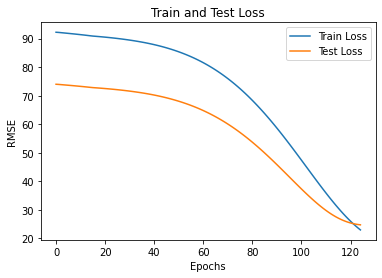

Test RMSE at timestamp 2014-06-11 00:00:00
GNN:  tensor(24.7083)
Min Test RMSE:  24.781919479370117
RF:  tensor(28.8616, dtype=torch.float64)
Mean:  tensor(32.1183)
----------------------------------------


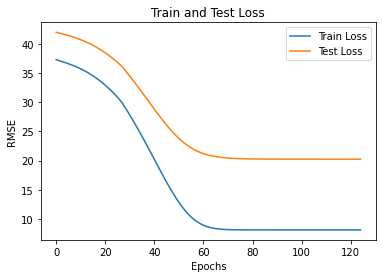

Test RMSE at timestamp 2014-06-12 00:00:00
GNN:  tensor(20.2516)
Min Test RMSE:  20.251708984375
RF:  tensor(23.3434, dtype=torch.float64)
Mean:  tensor(21.3626)
----------------------------------------


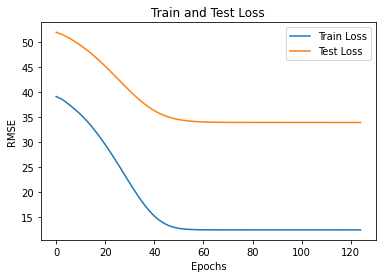

Test RMSE at timestamp 2014-06-13 00:00:00
GNN:  tensor(33.9736)
Min Test RMSE:  33.973487854003906
RF:  tensor(36.5228, dtype=torch.float64)
Mean:  tensor(34.1691)
----------------------------------------


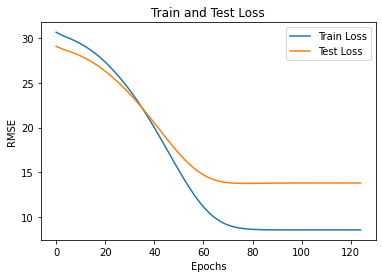

Test RMSE at timestamp 2014-06-14 00:00:00
GNN:  tensor(13.8127)
Min Test RMSE:  13.763718605041504
RF:  tensor(17.3750, dtype=torch.float64)
Mean:  tensor(14.4671)
----------------------------------------


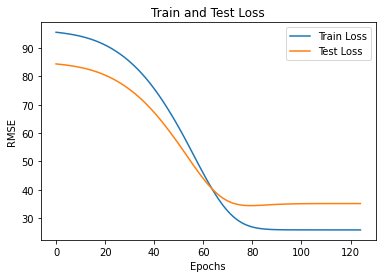

Test RMSE at timestamp 2014-06-15 00:00:00
GNN:  tensor(35.1507)
Min Test RMSE:  34.433170318603516
RF:  tensor(40.0803, dtype=torch.float64)
Mean:  tensor(37.0328)
----------------------------------------


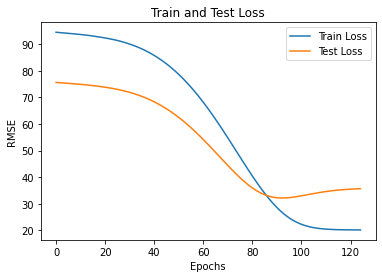

Test RMSE at timestamp 2014-06-16 00:00:00
GNN:  tensor(35.7098)
Min Test RMSE:  32.18385696411133
RF:  tensor(41.0384, dtype=torch.float64)
Mean:  tensor(39.7881)
----------------------------------------


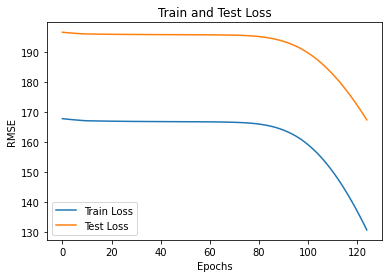

Test RMSE at timestamp 2014-06-17 00:00:00
GNN:  tensor(166.1953)
Min Test RMSE:  167.43309020996094
RF:  tensor(110.4963, dtype=torch.float64)
Mean:  tensor(101.6229)
----------------------------------------


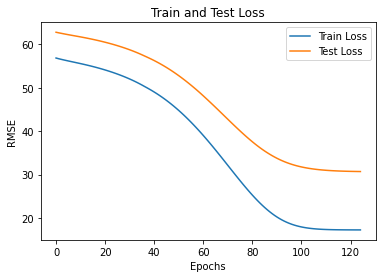

Test RMSE at timestamp 2014-06-18 00:00:00
GNN:  tensor(30.7098)
Min Test RMSE:  30.716508865356445
RF:  tensor(35.9621, dtype=torch.float64)
Mean:  tensor(30.4598)
----------------------------------------


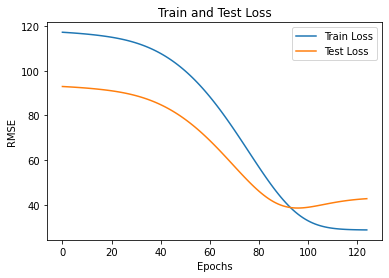

Test RMSE at timestamp 2014-06-19 00:00:00
GNN:  tensor(42.8013)
Min Test RMSE:  38.549903869628906
RF:  tensor(45.0551, dtype=torch.float64)
Mean:  tensor(48.8478)
----------------------------------------


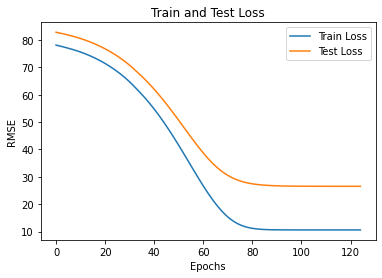

Test RMSE at timestamp 2014-06-20 00:00:00
GNN:  tensor(26.5422)
Min Test RMSE:  26.542253494262695
RF:  tensor(26.5700, dtype=torch.float64)
Mean:  tensor(25.9340)
----------------------------------------


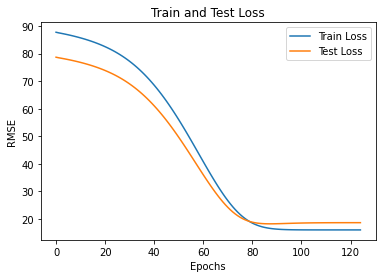

Test RMSE at timestamp 2014-06-21 00:00:00
GNN:  tensor(18.6817)
Min Test RMSE:  18.26185417175293
RF:  tensor(19.4565, dtype=torch.float64)
Mean:  tensor(20.9471)
----------------------------------------


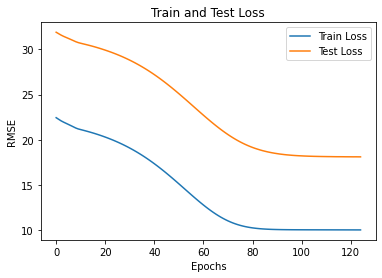

Test RMSE at timestamp 2014-06-22 00:00:00
GNN:  tensor(18.0991)
Min Test RMSE:  18.099803924560547
RF:  tensor(19.1447, dtype=torch.float64)
Mean:  tensor(17.4883)
----------------------------------------


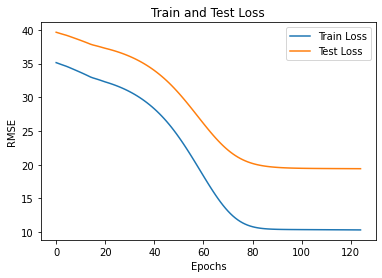

Test RMSE at timestamp 2014-06-23 00:00:00
GNN:  tensor(19.4092)
Min Test RMSE:  19.41071128845215
RF:  tensor(21.4861, dtype=torch.float64)
Mean:  tensor(19.0578)
----------------------------------------


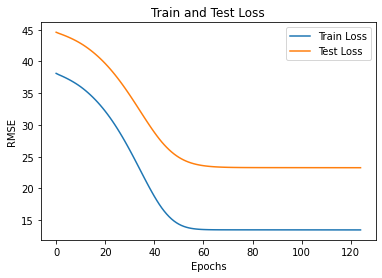

Test RMSE at timestamp 2014-06-24 00:00:00
GNN:  tensor(23.2659)
Min Test RMSE:  23.266265869140625
RF:  tensor(25.5202, dtype=torch.float64)
Mean:  tensor(23.1373)
----------------------------------------


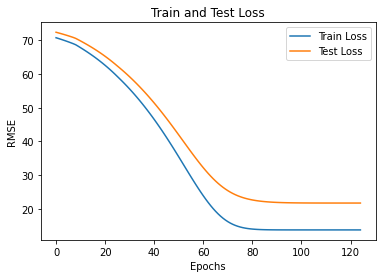

Test RMSE at timestamp 2014-06-25 00:00:00
GNN:  tensor(21.7610)
Min Test RMSE:  21.761140823364258
RF:  tensor(21.7458, dtype=torch.float64)
Mean:  tensor(21.0254)
----------------------------------------


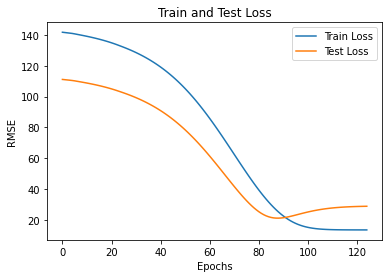

Test RMSE at timestamp 2014-06-26 00:00:00
GNN:  tensor(28.8341)
Min Test RMSE:  21.092302322387695
RF:  tensor(35.2974, dtype=torch.float64)
Mean:  tensor(39.7172)
----------------------------------------


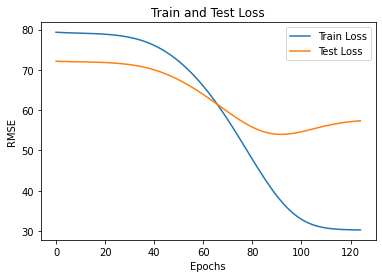

Test RMSE at timestamp 2014-06-27 00:00:00
GNN:  tensor(57.3943)
Min Test RMSE:  53.97571563720703
RF:  tensor(58.2902, dtype=torch.float64)
Mean:  tensor(59.8245)
----------------------------------------


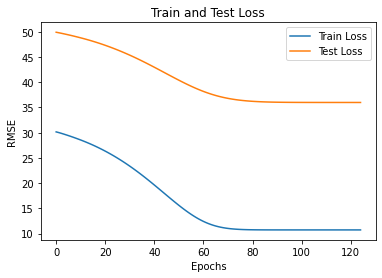

Test RMSE at timestamp 2014-06-28 00:00:00
GNN:  tensor(35.9937)
Min Test RMSE:  35.99375915527344
RF:  tensor(38.9541, dtype=torch.float64)
Mean:  tensor(35.9350)
----------------------------------------


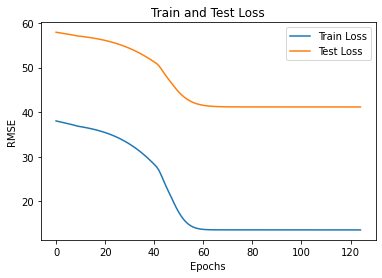

Test RMSE at timestamp 2014-06-29 00:00:00
GNN:  tensor(41.1741)
Min Test RMSE:  41.173377990722656
RF:  tensor(43.2153, dtype=torch.float64)
Mean:  tensor(40.4886)
----------------------------------------


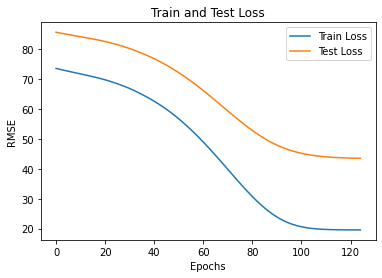

Test RMSE at timestamp 2014-06-30 00:00:00
GNN:  tensor(43.5471)
Min Test RMSE:  43.55971908569336
RF:  tensor(49.8401, dtype=torch.float64)
Mean:  tensor(43.2443)
----------------------------------------


In [6]:
p = pd.date_range(start='2014-06-01 00:00:00', end='2014-06-30 00:00:00', freq = '1D').to_frame(name='dates')

gnn_train, gnn_test, mean, rf_train, rf_test, train_list, test_list = [], [], [], [], [], [], []

for i in p['dates']:
    df_i = df[df['time'] == i]
    graph = create_graph(df_i, 10000)
    data, adj_matrix, train_adj, test_adj = dataset_generation(graph)
    
    gnn1, gnn2, m, rf1, rf2, gnnlist1, gnnlist2, min_test_rmse = run_models(data, adj_matrix, train_adj)
    
    gnn_train.append(gnn1)
    gnn_test.append(gnn2)
    mean.append(m)
    rf_train.append(rf1)
    rf_test.append(rf2)
    train_list.append(gnnlist1)
    test_list.append(gnnlist2)
    
    print('Test RMSE at timestamp', i)
    print('GNN: ', gnn2)
    print('Min Test RMSE: ', min_test_rmse)
    print('RF: ', rf2)
    print('Mean: ', m)
    print('----------------------------------------')

In [7]:
c_gnn = [1 if gnn_test[i] < min(rf_test[i], mean[i]) else 0 for i in range(len(rf_test))]
c_mean = [1 if mean[i] < min(rf_test[i], gnn_test[i]) else 0 for i in range(len(rf_test))]
c_rf = [1 if rf_test[i] < min(gnn_test[i], mean[i]) else 0 for i in range(len(rf_test))]

print('RF:', np.sum(c_rf))
print('GNN:', np.sum(c_gnn))
print('Mean:', np.sum(c_mean))

RF: 0
GNN: 18
Mean: 12


In [8]:
print('RF:', np.mean(rf_test))
print('GNN:', np.mean(gnn_test))
print('Mean:', np.mean(mean))

RF: 31.38554678009606
GNN: 30.486944
Mean: 29.74715


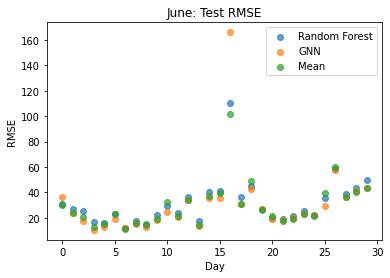

In [9]:
plt.scatter(range(len(rf_test)), rf_test, alpha = 0.7, label = 'Random Forest')
plt.scatter(range(len(rf_test)), gnn_test, alpha = 0.7, label = 'GNN')
plt.scatter(range(len(rf_test)), mean, alpha = 0.7, label = 'Mean')
plt.xlabel('Day')
plt.ylabel('RMSE')
plt.legend()
plt.title('June: Test RMSE')
plt.show();

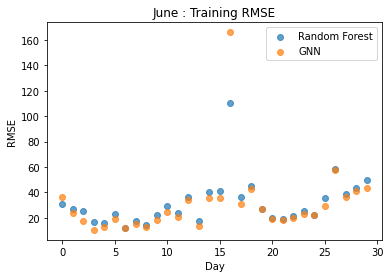

In [10]:
plt.scatter(range(len(rf_test)), rf_test, alpha = 0.7, label = 'Random Forest')
plt.scatter(range(len(rf_test)), gnn_test, alpha = 0.7, label = 'GNN')
plt.xlabel('Day')
plt.ylabel('RMSE')
plt.legend()
plt.title('June : Training RMSE')
plt.show();